In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
np.random.seed(1999)
import pandas as pd

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1XwPmv2pzMPo-t8yzG_Q4NkSp-ZHV1wLU/view?usp=sharing' # The shareable link
id = '1XwPmv2pzMPo-t8yzG_Q4NkSp-ZHV1wLU'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv', sep=";")
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

## Data Dictionary
| Column | Variable | Class |
| --- | --------------- | --- |
| age | age of customer | |
| job | type of job | categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown" |
| marital | marital status | categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed |
| education | highest degree of customer | categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown" |
| default | has credit in default? | categorical: "no","yes","unknown" |
| housing | has housing loan? | categorical: "no","yes","unknown" |
| loan | has personal loan? | categorical: "no","yes","unknown" |
| contact | contact communication type | categorical: "cellular","telephone" |
| month | last contact month of year | categorical: "jan", "feb", "mar", ..., "nov", "dec" | 
| day_of_week | last contact day of the week | categorical: "mon","tue","wed","thu","fri" |
| campaign | number of contacts performed during this campaign and for this client | numeric, includes last contact |
| pdays | number of days that passed by after the client was last contacted from a previous campaign | numeric; 999 means client was not previously contacted |
| previous | number of contacts performed before this campaign and for this client | numeric |
| poutcome | outcome of the previous marketing campaign | categorical: "failure","nonexistent","success" |
| emp.var.rate | employment variation rate - quarterly indicator | numeric |
| cons.price.idx | consumer price index - monthly indicator | numeric   | 
| cons.conf.idx | consumer confidence index - monthly indicator | numeric |   
| euribor3m | euribor 3 month rate - daily indicator | numeric |
| nr.employed | number of employees - quarterly indicator | numeric |
| y | has the client subscribed a term deposit? | binary: "yes","no" |

## **Preprocessing**: 


**Preprocessing: Drop Columns with too many null values, add datetime values, dealing with missing data**
- Drop "pdays" and "duration" columns
- Add Year column
- Randomly assign missing data a value base on the distribution of known data

In [ ]:
# Drop duration
duration = df['duration']
df.drop(columns = ['duration'], inplace = True)
#Duration: last contact duration, in seconds (numeric). 
#This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. 
#Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

# Add Year column
prev = df.month[0]
year = 2008
lt = []
for item in df.month:
    if item != prev:
        if prev == 'dec':
            year+=1
    prev = item
    lt.append(year)

df['year'] = lt

In [ ]:
# Data Preprocessing
# This function generate a dataframe containing all the 'feature', 'Non-null-count', 'dtype', 'number_of_unique_values', 'unique_values' for variables 
def info_df_generator(df):
    lt = []
    for col in df.columns:
        col_non_null_count = df[col].count()
        cell_type= df[col].dtypes
        unique_size = df[col].unique().size
        unique_value = df[col].unique()
        lt.append([col, col_non_null_count,cell_type,unique_size, unique_value])
    info_df = pd.DataFrame(lt, columns = ['feature', 'Non-null-count', 'dtype', 'number_of_unique_values', 'unique_values'])
    return(info_df)


In [ ]:
def col_name_w_unknown_list(df):   
    col_name_w_unknown = []
    for index, row in info_df_generator(df).iterrows():
        if row.dtype == 'object':
            if 'unknown' in list(row.unique_values):
                col_name_w_unknown.append(row.feature)
    return col_name_w_unknown

# missing value for columns contains categorical values is 'unknown'
# Print all columns containing categorical values to see the distribution
def print_unknown_percentage(df):
    for col in col_name_w_unknown_list(df):
        print(f'Percentage of Missing data in {col} Column:')
        print(df[df[f'{col}'] == 'unknown'][f'{col}'].value_counts()[0]/df.shape[0])

print_unknown_percentage(df)

Percentage of Missing data in job Column:
0.008012042342429833
Percentage of Missing data in marital Column:
0.0019423132951345051
Percentage of Missing data in education Column:
0.042026803923472855
Percentage of Missing data in default Column:
0.20872584247839177
Percentage of Missing data in housing Column:
0.0240361270272895
Percentage of Missing data in loan Column:
0.0240361270272895


In [ ]:
#This funtion return a dictionary contains the percentage of each categories other than missing in this column 
def distribution_recorder(df, col):   
    df_small = pd.DataFrame(df[col].value_counts()).reset_index()
    record = {}
    for i, r in df_small.iterrows():
        if r['index'] == 'unknown':
            pass
        else:
            record[r['index']] = r[col]/df_small[df_small['index']!='unknown'][col].sum()
    return record
    
#This function generate a random category based on the existed distribution
def value_generator(record):
    # Generate a random uniform variable from (0,1) as cdf to decide which value this missing one should take 
    x = np.random.uniform()
    cdf = 0
    for key, value in record.items():
        cdf += value
        if x < cdf:
            return key
            break

def fulfill_(x, record):
    if x == 'unknown':
        return value_generator(record)
    else:
        return x

#Randomly assign value to missing values using the distrition of this attribute 
for col in col_name_w_unknown_list(df):
    record = distribution_recorder(df, col)
    df[col] = df[col].apply(lambda x: fulfill_(x, record))

In [ ]:
#check if there is any unknown?
col_name_w_unknown_list(df)
#We can see that now there is no unknown value any more

[]

unknown count of pdays:
0.9632174419733903


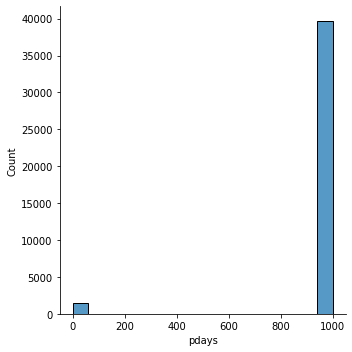

In [ ]:
# missing values in numerical attributes 
print(f'unknown count of pdays:')
print(int(df[df.pdays == 999].pdays.value_counts().values)/df.shape[0])

import seaborn as sns
sns.displot(df, x = 'pdays')

In [ ]:
# drop pdays
# because most of pdays are missing value
df.drop(columns = 'pdays', inplace = True)

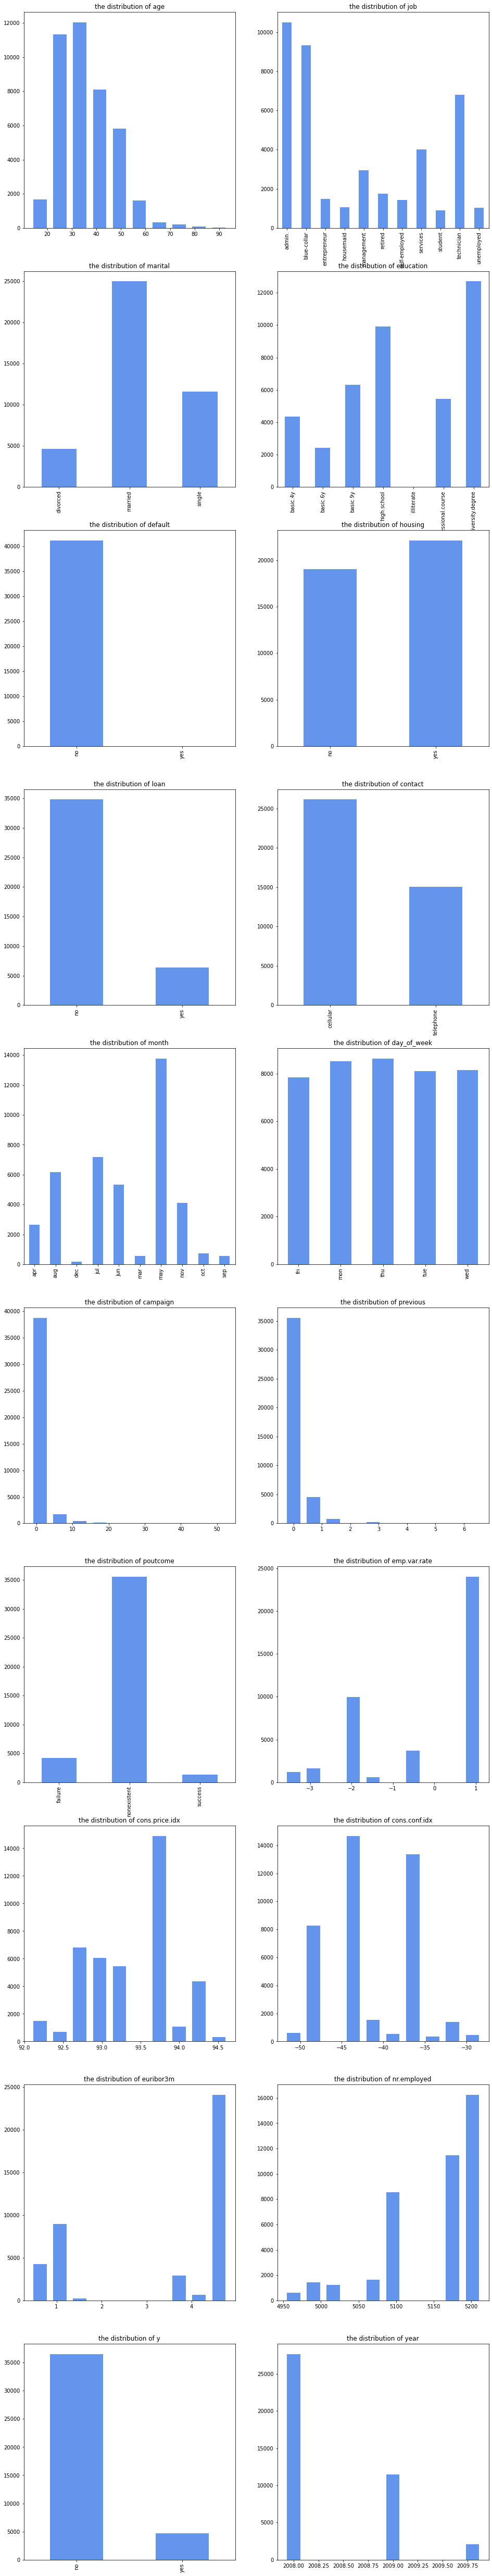

In [ ]:
# We might want to take a look at the general distribution of our data before doing the data analytics job 
def attribute_plot(df):
    COL_NUM = 2
    ROW_NUM = df.shape[1]//2 if df.shape[1]%2 == 0 else (df.shape[1]//2+1)

    fig,axes = plt.subplots(ROW_NUM, COL_NUM, figsize = (16,90))

    for index, row in info_df_generator(df).iterrows():
        ax = axes[int(index/COL_NUM),index%COL_NUM]
        if row['dtype'] == 'object':
            #a_heights, a_bins = np.histogram(df.groupby(row['feature']).size())
            df.groupby(row['feature']).size().plot(kind='bar', ax=ax,facecolor='cornflowerblue')
        else:
            a_heights, a_bins = np.histogram(df[row.feature])
            width = (a_bins[1] - a_bins[0])/1.5
            ax.bar(a_bins[:-1], a_heights, width=width,facecolor='cornflowerblue')
            

        ax.set_title(f'the distribution of {row.feature}')
        ax.set(xlabel=None)

attribute_plot(df)

In [ ]:
df.select_dtypes(include='number')

age  campaign  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
0       56         1         0           1.1          93.994          -36.4   
1       57         1         0           1.1          93.994          -36.4   
2       37         1         0           1.1          93.994          -36.4   
3       40         1         0           1.1          93.994          -36.4   
4       56         1         0           1.1          93.994          -36.4   
...    ...       ...       ...           ...             ...            ...   
41183   73         1         0          -1.1          94.767          -50.8   
41184   46         1         0          -1.1          94.767          -50.8   
41185   56         2         0          -1.1          94.767          -50.8   
41186   44         1         0          -1.1          94.767          -50.8   
41187   74         3         1          -1.1          94.767          -50.8   

       euribor3m  nr.employed  year  
0          4.857       5191.0  2008  
1          4.857       5191.0  2008  
2          4.857       5191.0  2008  
3          4.857       5191.0  2008  
4          4.857       5191.0  2008  
...          ...          ...   ...  
41183      1.028       4963.6  2010  
41184      1.028       4963.6  2010  
41185      1.028       4963.6  2010  
41186      1.028       4963.6  2010  
41187      1.028       4963.6  2010  

[41188 rows x 9 columns]

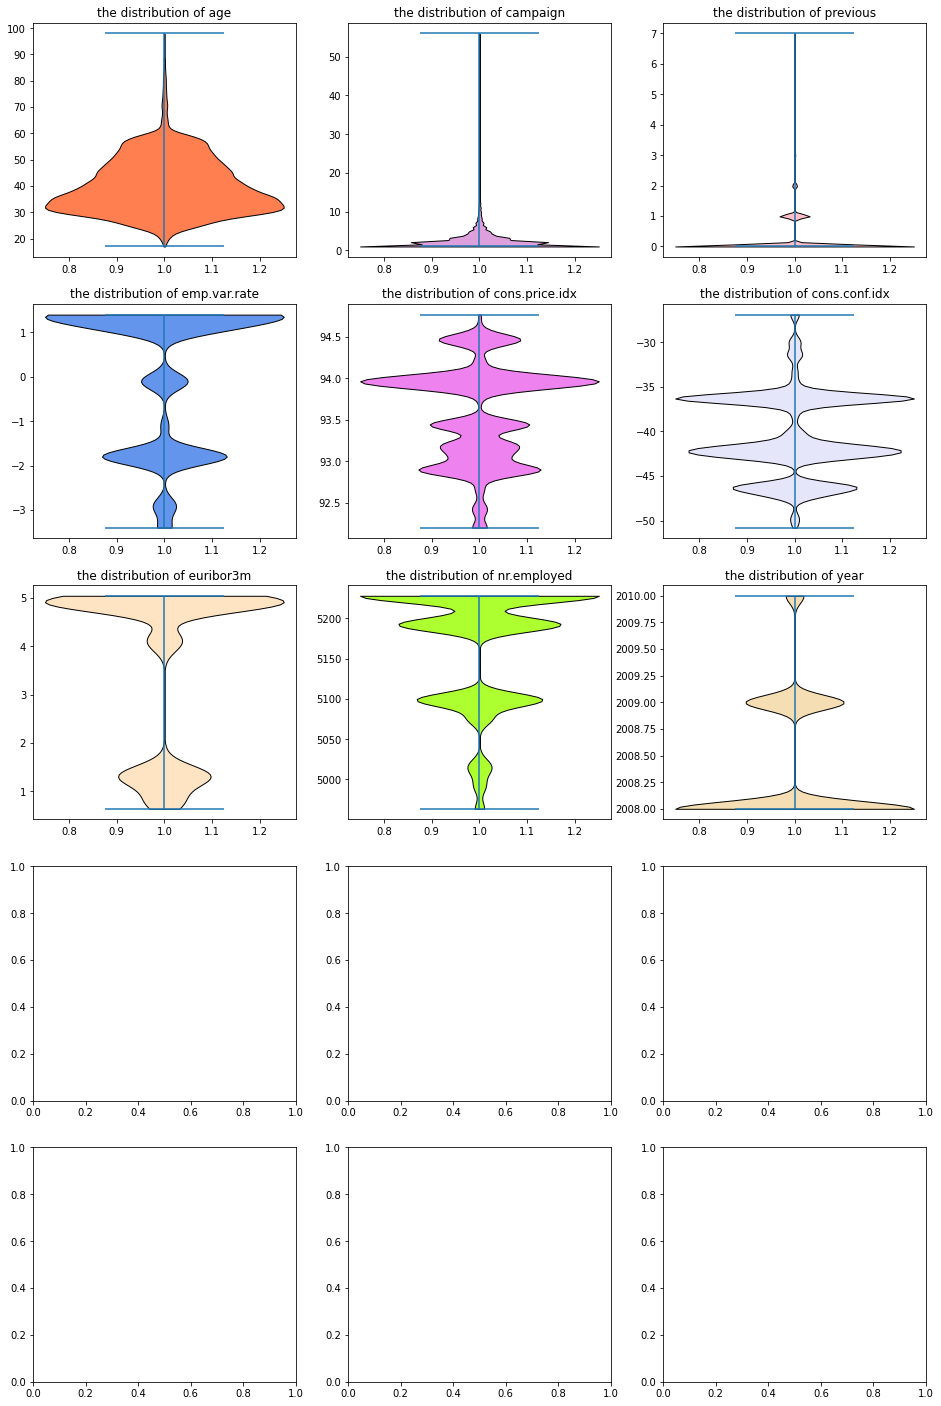

In [ ]:
# Violin plot
c = ['coral','plum','pink','cornflowerblue','violet','lavender','bisque','greenyellow','wheat']
df_cont = df.select_dtypes(include='number')
def attribute_plot2(df):
    COL_NUM = 3
    ROW_NUM = df.shape[1]//3 if df.shape[1]%2 == 0 else (df.shape[1]//2+1)

    fig,axes = plt.subplots(ROW_NUM, COL_NUM, figsize = (16,25))

    for index, row in info_df_generator(df).iterrows():
        ax = axes[int(index/COL_NUM),index%COL_NUM]
        
        parts = ax.violinplot(df[row['feature']])#, facecolor='cornflowerblue')
        for pc in parts['bodies']:
          pc.set_facecolor(c[index])
          pc.set_edgecolor('black')
          pc.set_alpha(1)


        ax.set_title(f'the distribution of {row.feature}')
        ax.set(xlabel=None)

attribute_plot2(df_cont)

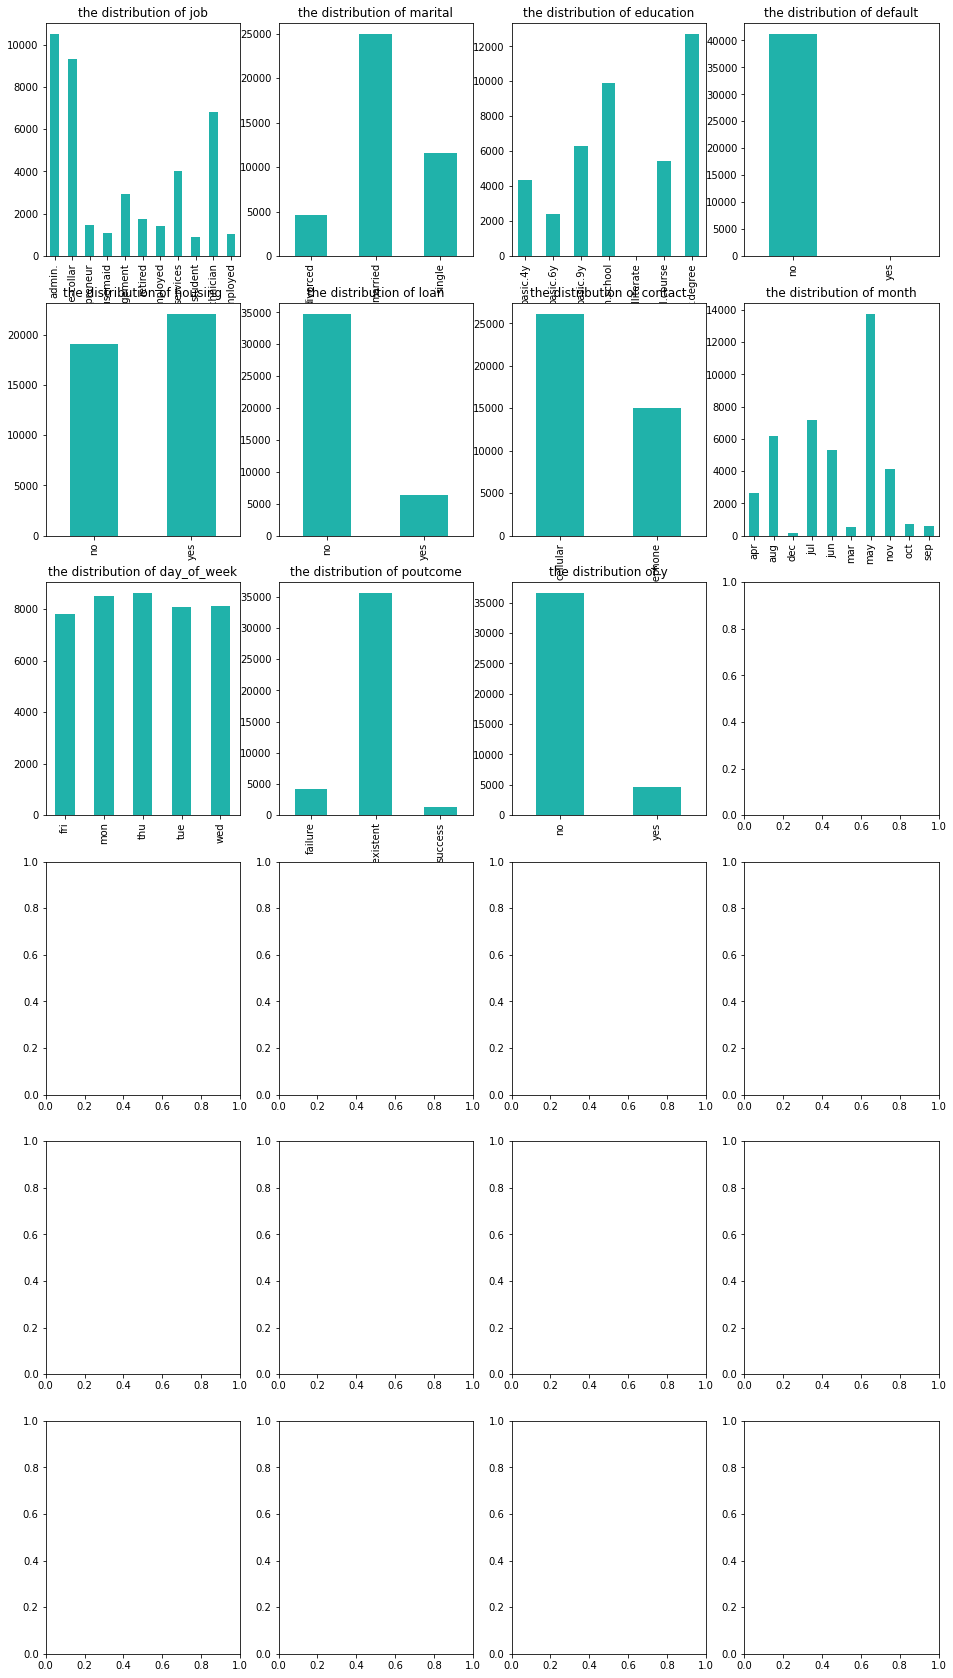

In [ ]:
c1 = ['coral','plum','pink','cornflowerblue','violet','lavender','bisque','greenyellow','wheat','seagreen','lightskyblue']
def attribute_plot3(df):
    COL_NUM = 4
    ROW_NUM = df.shape[1]//4 if df.shape[1]%2 == 0 else (df.shape[1]//2+1)

    fig,axes = plt.subplots(ROW_NUM, COL_NUM, figsize = (16,30))

    for index, row in info_df_generator(df).iterrows():
        ax = axes[int(index/COL_NUM),index%COL_NUM]
        if row['dtype'] == 'object':
            #a_heights, a_bins = np.histogram(df.groupby(row['feature']).size())
            df.groupby(row['feature']).size().plot(kind='bar', ax=ax,facecolor='lightseagreen') # facecolor = c1[index]
        
            

        ax.set_title(f'the distribution of {row.feature}')
        ax.set(xlabel=None)


attribute_plot3(df.select_dtypes(exclude='number'))

In [ ]:
df_nonpca_rf = df.copy()

# **PCA**

In [ ]:
# this function returns a list containing all column names with certain type
def type_list_generator(df, tp = 'object'):
    lt = []
    if type(tp) == str:
        for index, row in info_df_generator(df).iterrows():
            if row['dtype'] == tp:
                lt.append(row['feature'])
    if type(tp) == list:
        for index, row in info_df_generator(df).iterrows():
            if row['dtype'] in tp:
                lt.append(row['feature'])
    return lt

def df_w_dummy_generator(Regression = True, col = type_list_generator(df), df = df):
    
    if Regression:
        df_copy = pd.get_dummies(data = df, columns = col, drop_first = True)
    else:
        df_copy = pd.get_dummies(data = df, columns = col)
    return df_copy



In [ ]:
pd.set_option('display.max_columns', 50)

In [ ]:
# PCA no rotation
!pip install factor-analyzer
import factor_analyzer
# just use pca on dummy variables to decrease the number of dummy columns

# we want to set a baseline dummy to avoid overfitting problem
df_d = df_w_dummy_generator(Regression = True, col = type_list_generator(df, tp = 'object'),
                            df = df[type_list_generator(df, tp = 'object')])
pca_without_rotation = factor_analyzer.FactorAnalyzer(n_factors=45,
                                          rotation=None,
                                          method='principal').fit(df_d.drop(columns = ['y_yes']))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pca_index_names = list(df_d.drop(columns = ['y_yes']).columns)


In [ ]:
# some functions to format PCA results
def get_loadings_communalities(pca,round_dig=2,index_names=pca_index_names):
    df = pd.DataFrame(
      pca.loadings_,
      index=index_names if index_names else [f'q{i}' for i in range(1,1+pca.loadings_.shape[0])],
      columns=[f'RC{i}' for i in range(1,1+pca.loadings_.shape[1])] if pca.rotation else [f'PC{i}' for i in range(1,1+pca.loadings_.shape[1])]
      )
    if pca.rotation:
        df['communalities']=pca.get_communalities()
    df=df.round(3)
    return  df

def get_summary(pca,round_dig=2):
  ''' Print a summary of the PCA fit '''
  return pd.DataFrame(
      [pca.get_factor_variance()[0],
       pca.get_factor_variance()[1],
       pca.get_factor_variance()[2]],
       columns=['PC{}'.format(i) for i in
                range(1,1+len(pca.get_factor_variance()[0]))],
      index=['Sum of Squares Loadings','Proportion of Variance Explained',
             'Cumulative Proportion']
            ).round(round_dig)


In [ ]:
get_summary(pca_without_rotation)

PC1   PC2   PC3   PC4   PC5   PC6   PC7  \
Sum of Squares Loadings           2.39  1.92  1.74  1.64  1.60  1.55  1.33   
Proportion of Variance Explained  0.06  0.05  0.05  0.04  0.04  0.04  0.04   
Cumulative Proportion             0.06  0.12  0.16  0.21  0.25  0.29  0.33   

                                   PC8   PC9  PC10  PC11  PC12  PC13  PC14  \
Sum of Squares Loadings           1.26  1.25  1.24  1.19  1.12  1.09  1.05   
Proportion of Variance Explained  0.03  0.03  0.03  0.03  0.03  0.03  0.03   
Cumulative Proportion             0.36  0.40  0.43  0.46  0.49  0.52  0.55   

                                  PC15  PC16  PC17  PC18  PC19  PC20  PC21  \
Sum of Squares Loadings           1.05  1.03  1.03  1.02  1.02  1.00  1.00   
Proportion of Variance Explained  0.03  0.03  0.03  0.03  0.03  0.03  0.03   
Cumulative Proportion             0.58  0.61  0.64  0.66  0.69  0.72  0.74   

                                  PC22  PC23  PC24  PC25  PC26  PC27  PC28  \
Sum of Squares Loadings           0.99  0.99  0.96  0.94  0.92  0.81  0.75   
Proportion of Variance Explained  0.03  0.03  0.03  0.03  0.02  0.02  0.02   
Cumulative Proportion             0.77  0.80  0.82  0.85  0.87  0.90  0.92   

                                  PC29  PC30  PC31  PC32  PC33  PC34  PC35  \
Sum of Squares Loadings           0.71  0.58  0.55  0.37  0.25  0.24  0.22   
Proportion of Variance Explained  0.02  0.02  0.01  0.01  0.01  0.01  0.01   
Cumulative Proportion             0.94  0.95  0.97  0.98  0.98  0.99  1.00   

                                  PC36  PC37  
Sum of Squares Loadings            0.1  0.08  
Proportion of Variance Explained   0.0  0.00  
Cumulative Proportion              1.0  1.00

Text(0, 0.5, 'Variance')

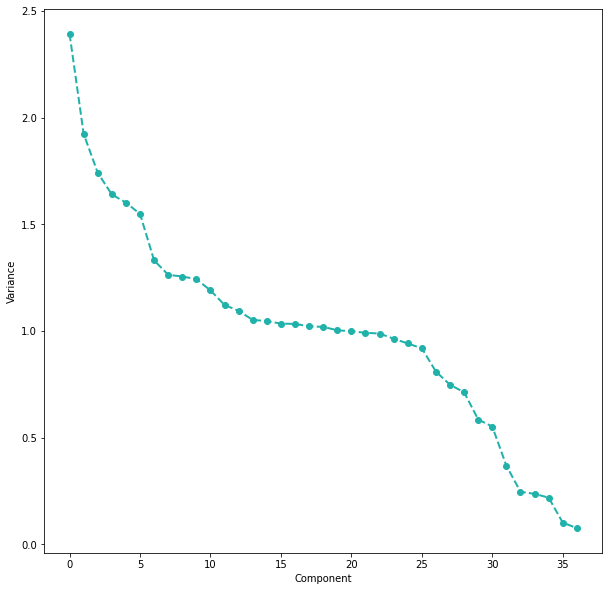

In [ ]:
# scree plot - shows successive proportion of additional variance that each component adds
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(pca_without_rotation.get_factor_variance()[0])),
         pca_without_rotation.get_factor_variance()[0],color='lightseagreen', marker='o', linestyle='dashed',
     linewidth=2, markersize=6 )
plt.xlabel('Component')
plt.ylabel('Variance')

In [ ]:
# PCA - Varimax Rotation
pca_rotated = factor_analyzer.FactorAnalyzer(n_factors=6,
                                          rotation='varimax',
                                          method='principal').fit(df_d.drop(columns = ['y_yes']))

In [ ]:
get_loadings_communalities(pca_rotated).sort_values(by = ['communalities'],ascending=False)
#we can use this line to decide which one is which 

RC1    RC2    RC3    RC4    RC5    RC6  \
marital_single                 0.009 -0.906 -0.022  0.034 -0.093 -0.074   
marital_married               -0.008  0.883  0.030 -0.047  0.122  0.077   
education_university.degree   -0.077 -0.160  0.046 -0.796 -0.330 -0.069   
education_high.school         -0.349 -0.011 -0.010  0.632 -0.463  0.047   
contact_telephone             -0.002  0.009 -0.268  0.020  0.052  0.800   
job_blue-collar               -0.151  0.052 -0.138  0.111  0.801  0.043   
education_professional.course  0.796  0.041  0.051  0.195 -0.030 -0.002   
job_technician                 0.803 -0.067 -0.002  0.096 -0.124 -0.044   
poutcome_nonexistent           0.072  0.073 -0.786 -0.050 -0.055  0.037   
poutcome_success              -0.015 -0.069  0.727  0.019  0.034 -0.016   
job_services                  -0.312  0.070 -0.062  0.514 -0.361  0.050   
month_jul                     -0.144 -0.055 -0.317  0.160  0.081 -0.569   
education_basic.9y            -0.137 -0.016 -0.068  0.031  0.661 -0.006   
month_may                     -0.094 -0.059  0.035  0.140  0.210  0.601   
job_management                -0.199  0.111  0.022 -0.465 -0.202  0.051   
month_aug                      0.309  0.120 -0.028 -0.174 -0.194 -0.355   
month_jun                      0.054 -0.004 -0.186 -0.066 -0.081  0.452   
job_student                   -0.080 -0.383  0.175  0.064 -0.024 -0.000   
education_basic.6y            -0.093  0.116 -0.035  0.070  0.300  0.028   
month_sep                      0.018 -0.018  0.340 -0.006 -0.030  0.015   
month_nov                     -0.090  0.090  0.156 -0.132 -0.092 -0.217   
job_retired                   -0.004  0.195  0.244  0.014 -0.033 -0.052   
month_oct                      0.007 -0.030  0.284  0.007 -0.014 -0.014   
job_self-employed             -0.059 -0.015 -0.020 -0.227 -0.028 -0.004   
month_mar                      0.006 -0.087  0.185 -0.040  0.001 -0.043   
month_dec                     -0.006  0.000  0.175 -0.005 -0.005 -0.010   
job_entrepreneur              -0.070  0.077 -0.028 -0.121 -0.054  0.046   
housing_yes                    0.009 -0.002  0.066  0.008  0.004 -0.146   
day_of_week_thu                0.047 -0.036 -0.014 -0.002  0.022 -0.130   
job_housemaid                  0.007  0.089 -0.049  0.013 -0.023 -0.024   
day_of_week_wed                0.004 -0.036  0.007  0.007  0.063  0.053   
job_unemployed                -0.006  0.033  0.063  0.025 -0.039  0.010   
day_of_week_mon               -0.026  0.021 -0.029 -0.025 -0.065  0.020   
day_of_week_tue               -0.026  0.050  0.029  0.022 -0.018 -0.009   
education_illiterate           0.001  0.018 -0.015 -0.001  0.035 -0.051   
loan_yes                       0.006 -0.016 -0.028  0.013 -0.013 -0.041   
default_yes                    0.054  0.003 -0.008  0.003 -0.007 -0.003   

                               communalities  
marital_single                         0.837  
marital_married                        0.804  
education_university.degree            0.780  
education_high.school                  0.737  
contact_telephone                      0.716  
job_blue-collar                        0.700  
education_professional.course          0.677  
job_technician                         0.676  
poutcome_nonexistent                   0.635  
poutcome_success                       0.535  
job_services                           0.503  
month_jul                              0.481  
education_basic.9y                     0.461  
month_may                              0.439  
job_management                         0.312  
month_aug                              0.304  
month_jun                              0.253  
job_student                            0.188  
education_basic.6y                     0.119  
month_sep                              0.117  
month_nov                              0.113  
job_retired                            0.101  
month_oct                              0.082  
job_self-employed                      0.057  
month_m

In [ ]:
dummy_X_scores = pca_rotated.transform(df_d.drop(columns = ['y_yes']))
df_pca = pd.DataFrame(dummy_X_scores,columns=[f'RC{i}' for i in range(1,7)])
df_pca.head(5)

RC1       RC2       RC3       RC4       RC5       RC6
0  0.034909  0.808767 -0.483958  0.005638 -0.099564  1.315521
1 -1.144304  0.866985 -0.348119  1.783892 -1.464719  1.444093
2 -1.144365  0.880220 -0.279587  1.809061 -1.443938  1.280431
3 -0.264034  0.773882 -0.254825  0.098731  0.661202  1.328933
4 -1.113515  0.838905 -0.417352  1.822738 -1.487128  1.375273

# **Scaling**

In [ ]:
from sklearn import preprocessing
df_cont = pd.DataFrame(preprocessing.scale(df[type_list_generator(df=df,tp = ['float64','int64'])]),columns = type_list_generator(df=df,tp = ['float64','int64']))

In [ ]:
df_new = df_cont.merge(df_pca,left_index = True, right_index = True)

In [ ]:
df_new.head(10)

age  campaign  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
0  1.533034 -0.565922 -0.349494      0.648092        0.722722       0.886447   
1  1.628993 -0.565922 -0.349494      0.648092        0.722722       0.886447   
2 -0.290186 -0.565922 -0.349494      0.648092        0.722722       0.886447   
3 -0.002309 -0.565922 -0.349494      0.648092        0.722722       0.886447   
4  1.533034 -0.565922 -0.349494      0.648092        0.722722       0.886447   
5  0.477486 -0.565922 -0.349494      0.648092        0.722722       0.886447   
6  1.820911 -0.565922 -0.349494      0.648092        0.722722       0.886447   
7  0.093650 -0.565922 -0.349494      0.648092        0.722722       0.886447   
8 -1.537652 -0.565922 -0.349494      0.648092        0.722722       0.886447   
9 -1.441693 -0.565922 -0.349494      0.648092        0.722722       0.886447   

   euribor3m  nr.employed      year       RC1       RC2       RC3       RC4  \
0    0.71246      0.33168 -0.652565  0.034909  0.808767 -0.483958  0.005638   
1    0.71246      0.33168 -0.652565 -1.144304  0.866985 -0.348119  1.783892   
2    0.71246      0.33168 -0.652565 -1.144365  0.880220 -0.279587  1.809061   
3    0.71246      0.33168 -0.652565 -0.264034  0.773882 -0.254825  0.098731   
4    0.71246      0.33168 -0.652565 -1.113515  0.838905 -0.417352  1.822738   
5    0.71246      0.33168 -0.652565 -0.867837  0.676913 -0.372465  0.928465   
6    0.71246      0.33168 -0.652565  1.267119  0.659832 -0.144193  0.327994   
7    0.71246      0.33168 -0.652565 -0.663565  0.579584 -0.379306  0.874811   
8    0.71246      0.33168 -0.652565  2.513671 -1.396606 -0.287733  0.634790   
9    0.71246      0.33168 -0.652565 -1.137962 -1.114274 -0.472331  1.875151   

        RC5       RC6  
0 -0.099564  1.315521  
1 -1.464719  1.444093  
2 -1.443938  1.280431  
3  0.661202  1.328933  
4 -1.487128  1.375273  
5  0.227656  1.263415  
6 -0.012844  1.460434  
7  0.350729  1.353246  
8 -0.125522  1.228028  
9 -1.463387  1.189748

# **Clustering**

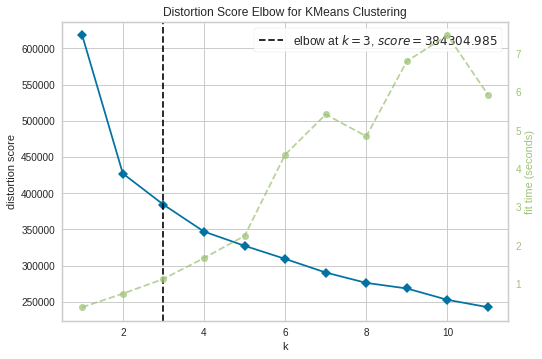

In [ ]:
from sklearn import cluster
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
def check_clusters(data,labels):
  print(list(zip(*np.unique(labels,return_counts=True))))

  return pd.pivot_table(data,index=labels)

#df_kmeans=pd.DataFrame(preprocessing.scale(df_new), columns = df_new.columns)
df_kmeans = df_new
# df_kmeans = df_kmeans.drop(['age'],axis = 1)
model_kmeans = KMeans()
visualizer = KElbowVisualizer(model_kmeans, k=(1,12)).fit(df_kmeans)
visualizer.show()

In [ ]:
centroids, labels, inertia = cluster.k_means(df_kmeans,n_clusters=2,random_state=1690)
check_clusters(df_kmeans,labels)

[(0, 13534), (1, 27654)]


RC1       RC2       RC3       RC4       RC5       RC6       age  \
0 -0.095437 -0.208607  0.764498  0.064729  0.072769 -0.004557 -0.033236   
1  0.046707  0.102093 -0.374149 -0.031678 -0.035613  0.002230  0.016266   

   campaign  cons.conf.idx  cons.price.idx  emp.var.rate  euribor3m  \
0 -0.171699      -0.460806       -0.945491     -1.346865  -1.409889   
1  0.084030       0.225520        0.462728      0.659162   0.690006   

   nr.employed  previous      year  
0    -1.311423  0.609909  1.333385  
1     0.641817 -0.298493 -0.652565

In [ ]:
df_kmeans.describe()

age      campaign      previous  emp.var.rate  cons.price.idx  \
count  4.118800e+04  4.118800e+04  4.118800e+04  4.118800e+04    4.118800e+04   
mean  -1.880382e-16 -7.590531e-17  5.520386e-18  7.797546e-17   -3.315820e-14   
std    1.000012e+00  1.000012e+00  1.000012e+00  1.000012e+00    1.000012e+00   
min   -2.209365e+00 -5.659220e-01 -3.494943e-01 -2.216433e+00   -2.374889e+00   
25%   -7.699804e-01 -5.659220e-01 -3.494943e-01 -1.197935e+00   -8.649547e-01   
50%   -1.942267e-01 -2.049085e-01 -3.494943e-01  6.480923e-01    2.994571e-01   
75%    6.694038e-01  1.561049e-01 -3.494943e-01  8.390606e-01    7.227225e-01   
max    5.563310e+00  1.928982e+01  1.379492e+01  8.390606e-01    2.058168e+00   

       cons.conf.idx     euribor3m   nr.employed          year           RC1  \
count   4.118800e+04  41188.000000  4.118800e+04  4.118800e+04  4.118800e+04   
mean   -1.352495e-16      0.000000 -1.024860e-14 -1.439579e-13 -1.174807e-16   
std     1.000012e+00      1.000012  1.000012e+00  1.000012e+00  1.000374e+00   
min    -2.224953e+00     -1.722351 -2.815697e+00 -6.525652e-01 -1.588680e+00   
25%    -4.747909e-01     -1.312994 -9.402810e-01 -6.525652e-01 -6.034396e-01   
50%    -2.803284e-01      0.712460  3.316799e-01 -6.525652e-01 -3.185743e-01   
75%     8.864466e-01      0.772422  8.451701e-01  1.075248e+00  2.213671e-01   
max     2.939106e+00      0.820853  8.451701e-01  2.803060e+00  7.561036e+00   

                RC2           RC3           RC4           RC5           RC6  
count  4.118800e+04  4.118800e+04  4.118800e+04  4.118800e+04  4.118800e+04  
mean  -4.830338e-18 -6.900483e-17 -5.554889e-17  1.462902e-16 -1.656116e-17  
std    1.000336e+00  9.994442e-01  1.000042e+00  9.997590e-01  1.000117e+00  
min   -3.329847e+00 -1.606247e+00 -2.385436e+00 -1.914522e+00 -3.338754e+00  
25%   -1.091100e+00 -5.644697e-01 -8.289547e-01 -6.618631e-01 -8.656815e-01  
50%    4.593085e-01 -2.519148e-01  1.367372e-01 -3.065269e-01 -9.498858e-02  
75%    7.423601e-01  3.603428e-02  6.877564e-01  6.611981e-01  1.101231e+00  
max    1.774994e+00  5.993068e+00  2.424432e+00  2.749034e+00  1.896146e+00

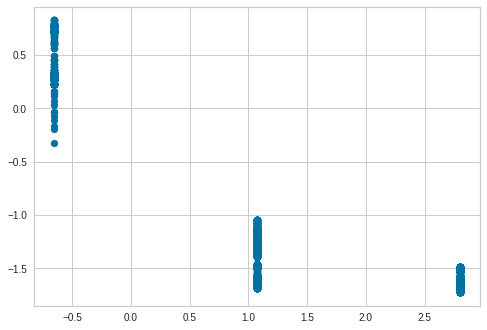

In [ ]:
plt.scatter('year','euribor3m',data = df_kmeans)

In [ ]:
df_labeled = pd.concat([df_kmeans[['RC3','euribor3m','age','cons.conf.idx']],pd.DataFrame(labels,columns = ['labels'])],axis = 1)

In [ ]:
df_labeled

RC3  euribor3m       age  cons.conf.idx  labels
0     -0.483958   0.712460  1.533034       0.886447       1
1     -0.348119   0.712460  1.628993       0.886447       1
2     -0.279587   0.712460 -0.290186       0.886447       1
3     -0.254825   0.712460 -0.002309       0.886447       1
4     -0.417352   0.712460  1.533034       0.886447       1
...         ...        ...       ...            ...     ...
41183  0.985557  -1.495186  3.164336      -2.224953       0
41184  0.099471  -1.495186  0.573445      -2.224953       0
41185  0.868218  -1.495186  1.533034      -2.224953       0
41186  0.197516  -1.495186  0.381527      -2.224953       0
41187  2.291291  -1.495186  3.260295      -2.224953       0

[41188 rows x 5 columns]

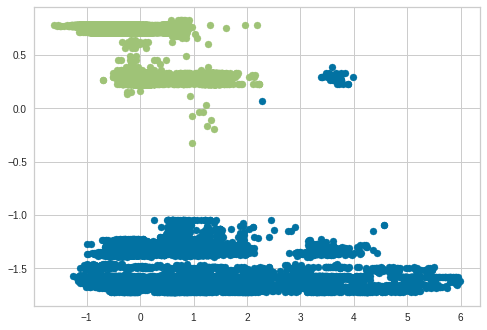

In [ ]:
# try to visualize clusters on 2D 

#Getting unique labels
import matplotlib.pyplot as plt
c = ['royalblue','darkseagreen','firebrick','lightsalmon']
u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(df_labeled[labels == i].iloc[:,0] , df_labeled[labels == i].iloc[:,1] ,marker ='o', cmap='viridis') # color = c[i]
plt.legend()
plt.show()

Text(0.5, 1.0, 'Age vs Consumer Confidence Index')

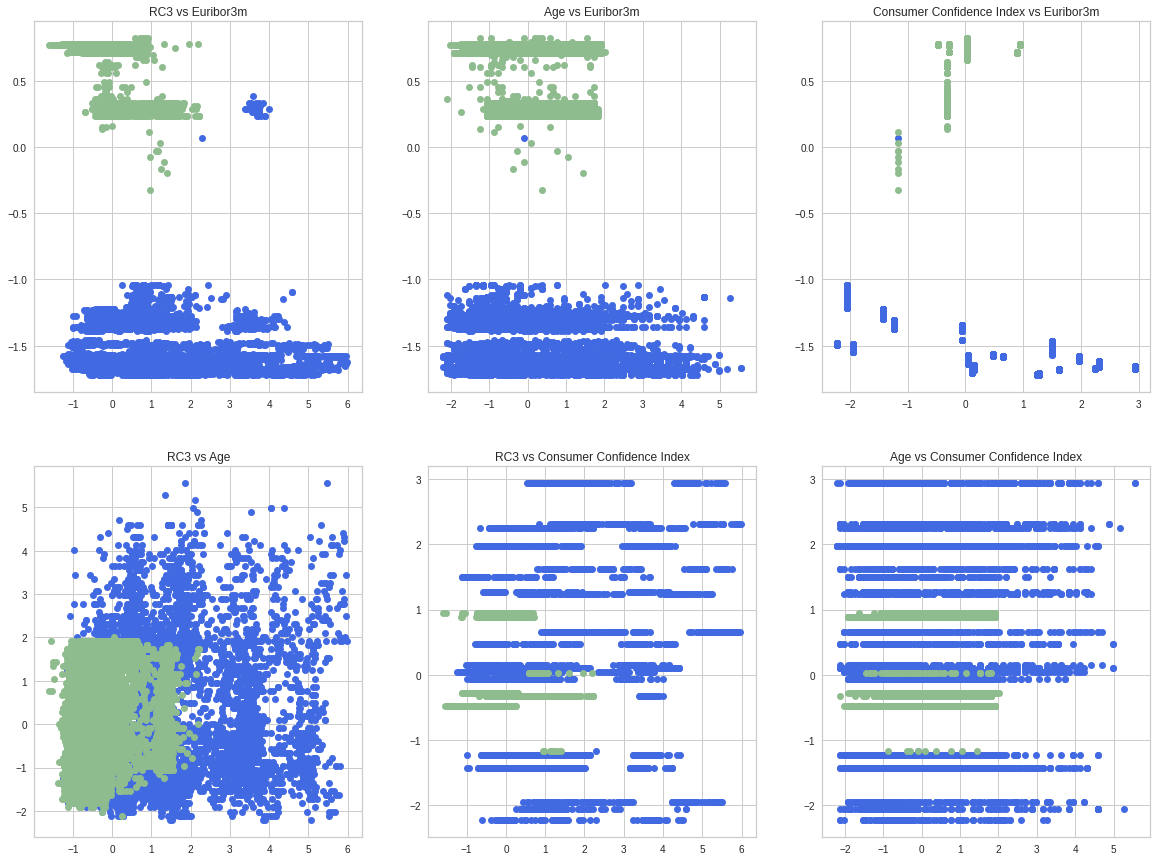

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(20, 15))

for i in u_labels:
    axs[0, 0].plot(df_labeled[labels == i].iloc[:,0] , df_labeled[labels == i].iloc[:,1] ,'s',marker ='o', color = c[i])
axs[0, 0].set_title('RC3 vs Euribor3m')

for i in u_labels:
    axs[0, 1].plot(df_labeled[labels == i].iloc[:,2] , df_labeled[labels == i].iloc[:,1] ,'s',marker ='o', color = c[i])
axs[0, 1].set_title('Age vs Euribor3m')

for i in u_labels:
    axs[0, 2].plot(df_labeled[labels == i].iloc[:,3] , df_labeled[labels == i].iloc[:,1] ,'s',marker ='o', color = c[i])
axs[0, 2].set_title('Consumer Confidence Index vs Euribor3m')

for i in u_labels:
    axs[1, 0].plot(df_labeled[labels == i].iloc[:,0] , df_labeled[labels == i].iloc[:,2] ,'s',marker ='o', color = c[i])
axs[1, 0].set_title('RC3 vs Age')

for i in u_labels:
    axs[1, 1].plot(df_labeled[labels == i].iloc[:,0] , df_labeled[labels == i].iloc[:,3] ,'s',marker ='o', color = c[i])
axs[1, 1].set_title('RC3 vs Consumer Confidence Index')

for i in u_labels:
    axs[1, 2].plot(df_labeled[labels == i].iloc[:,2] , df_labeled[labels == i].iloc[:,3] ,'s',marker ='o', color = c[i])
axs[1, 2].set_title('Age vs Consumer Confidence Index')

# fig.set_cmap('viridis')
# axs[0, 1].plot(x, y, 'tab:orange')
# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')


In [ ]:
df_labeled.iloc[:,[0,1,3]]

RC3  euribor3m  cons.conf.idx
0     -0.483958   0.712460       0.886447
1     -0.348119   0.712460       0.886447
2     -0.279587   0.712460       0.886447
3     -0.254825   0.712460       0.886447
4     -0.417352   0.712460       0.886447
...         ...        ...            ...
41183  0.985557  -1.495186      -2.224953
41184  0.099471  -1.495186      -2.224953
41185  0.868218  -1.495186      -2.224953
41186  0.197516  -1.495186      -2.224953
41187  2.291291  -1.495186      -2.224953

[41188 rows x 3 columns]

In [ ]:
import plotly.express as px
fig = px.scatter_3d(
    df_labeled.iloc[:,0:3], x='RC3', y='age', z='euribor3m', color=df_labeled['labels'],
    title='3d',
    labels={'RC3': 'RC3', 'euribor3m': '3 month Euribor ', 'age': 'Age'}
)
fig.update_traces(marker_size = 1)
fig.show()
# fig.write_html("3Dplot_2.html") #Modifiy the html file
# fig.show()
# import matplotlib.animation as animation
# def rotate(angle):
#     ax.view_init(azim=angle)
# rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
# plt.show()

In [ ]:
df_labeled = df_labeled.merge(df_d[['y_yes']],left_index = True, right_index = True)

In [ ]:
df_labeled

RC3  euribor3m       age  cons.conf.idx  labels  y_yes
0     -0.483958   0.712460  1.533034       0.886447       1      0
1     -0.348119   0.712460  1.628993       0.886447       1      0
2     -0.279587   0.712460 -0.290186       0.886447       1      0
3     -0.254825   0.712460 -0.002309       0.886447       1      0
4     -0.417352   0.712460  1.533034       0.886447       1      0
...         ...        ...       ...            ...     ...    ...
41183  0.985557  -1.495186  3.164336      -2.224953       0      1
41184  0.099471  -1.495186  0.573445      -2.224953       0      0
41185  0.868218  -1.495186  1.533034      -2.224953       0      0
41186  0.197516  -1.495186  0.381527      -2.224953       0      1
41187  2.291291  -1.495186  3.260295      -2.224953       0      0

[41188 rows x 6 columns]

In [ ]:
# label with real y
import plotly.express as px
fig = px.scatter_3d(
    df_labeled.iloc[:,0:3], x='RC3', y='age', z='euribor3m', color=df_labeled['y_yes'],
    title='3d',
    labels={'RC3': 'RC3', 'euribor3m': '3 month Euribor ', 'age': 'Age'}
)
fig.update_traces(marker_size = 1)
fig.show()

In [ ]:
# counts for subscriptions for low euribor
df_labeled[df_labeled['euribor3m']<0]['y_yes'].value_counts()

0    10203
1     3302
Name: y_yes, dtype: int64

In [ ]:
# counts for subscriptions for high euribor
df_labeled[df_labeled['euribor3m']>0]['y_yes'].value_counts()

0    26345
1     1338
Name: y_yes, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f319a62cd00>,
      dtype=object)

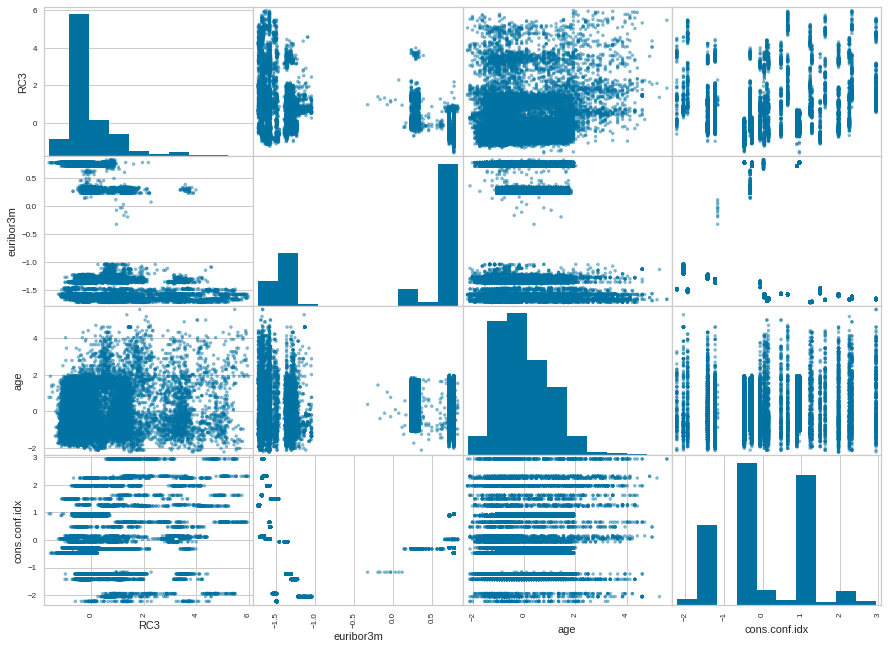

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_labeled.iloc[:,0:4], figsize=(15,11))

# New Section

## **Logistic Regression**

In [ ]:

y = df_w_dummy_generator(Regression = True, col = ['y'],df = df['y'])
df_lr = df_new.copy().merge(y, left_index = True, right_index = True)
# Avoid multicolinearity in Logistic Regression
# Drop Default because most of them are no
df_lr.drop(columns = ['emp.var.rate', 'nr.employed','year','cons.price.idx'],inplace = True)

df_lr.columns = [i.replace('.', '_') for i in df_lr.columns]

df_lr.rename(columns = {'yes':'Outcome'},inplace = True)

In [ ]:
#Logistic Preprocessing
from sklearn import preprocessing
l1 = type_list_generator(df_lr,'int64')
l2 = type_list_generator(df_lr,'float64')
l1.extend(l2)
df_lr[l1] = df_lr[l1].apply(lambda col: preprocessing.scale(col), axis = 0)

In [ ]:
# Train Test split 
import sklearn.linear_model as sk_lm
import sklearn.model_selection as sk_ms

df_train, df_test = sk_ms.train_test_split(df_lr, train_size=0.7, random_state=123)

logistic_reg = sk_lm.LogisticRegression(penalty='none')
X_train = df_train.drop(columns = ['Outcome'])
y_train = df_train.Outcome
X_test = df_test.drop(columns = ['Outcome'])

In [ ]:
import statsmodels.api as sm
log_reg_w_sm = sm.Logit(y_train, sm.add_constant(X_train)).fit()
log_reg_w_sm.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/usr/local/lib/python3.8/dist-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.8/dist-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully.
         Current function value: inf
         Iterations 7


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                28831
Model:                          Logit   Df Residuals:                    28819
Method:                           MLE   Df Model:                           11
Date:                Sun, 18 Dec 2022   Pseudo R-squ.:                     inf
Time:                        20:01:26   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4797      0.026    -97.013      0.000      -2.530      -2.430
age               0.0405      0.021      1.960      0.050    1.11e-05       0.081
campaign         -0.1194      0.031     -3.899      0.000      -0.179      -0.059
previous         -0.0693      0.021     -3.275      0.001      -0.111      -0.028
cons_conf_idx     0.1275      0.017      7.428      0.000       0.094       0.161
euribor3m        -0.7234      0.024    -30.531      0.000      -0.770      -0.677
RC1               0.0432      0.021      2.100      0.036       0.003       0.084
RC2              -0.1337      0.022     -6.198      0.000      -0.176      -0.091
RC3               0.3803      0.025     15.220      0.000       0.331       0.429
RC4              -0.0568      0.020     -2.804      0.005      -0.096      -0.017
RC5              -0.1187      0.023     -5.209      0.000      -0.163      -0.074
RC6              -0.3240      0.026    -12.327      0.000      -0.375      -0.272
=================================================================================
"""

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



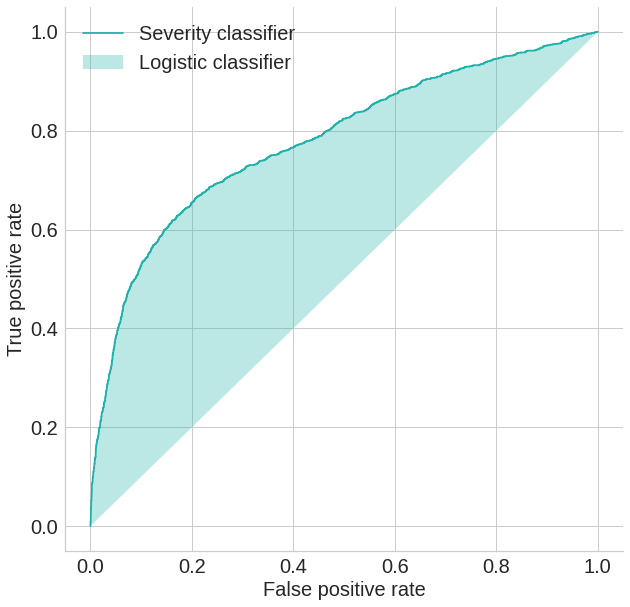

In [ ]:
def roc_drawer(model = log_reg_w_sm, y = 'Outcome', df = df_test, X = X_test, from_sm = False, from_sk = False): 
    
    df_w_result = df.copy()
    if from_sk:
        df_w_result['score'] = [i[1] for i in model.predict_proba(X)]
    elif from_sm:
        df_w_result['score'] = [i for i in model.predict(sm.add_constant(X))]
    else:
        df_w_result['score'] = [i for i in model.predict(X)]
    
    import sklearn.metrics as sk_m

    fpr_logistic, tpr_logistic, _ = sk_m.roc_curve(df_w_result[y], df_w_result['score'])

    plt.figure(figsize=(10, 10))

    plt.plot(fpr_logistic,tpr_logistic,color = 'lightseagreen')
    plt.fill(fpr_logistic, tpr_logistic, 'lightseagreen', alpha=0.3)

    plt.xlabel('False positive rate', fontsize=20)
    plt.ylabel('True positive rate', fontsize=20)

    plt.legend(['Severity classifier', 'Logistic classifier'], fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    sns.despine()
roc_drawer(from_sm = True) 

In [ ]:
np.where(log_reg_w_sm.predict(sm.add_constant(X_test))>0.2, 1,0)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



array([0, 1, 0, ..., 1, 1, 0])

R Square score between predict probability and real true/false decision  is:
0.17544677263006037


Confusion Matrix with a threshold of 1
[[10961     0]
 [ 1396     0]]


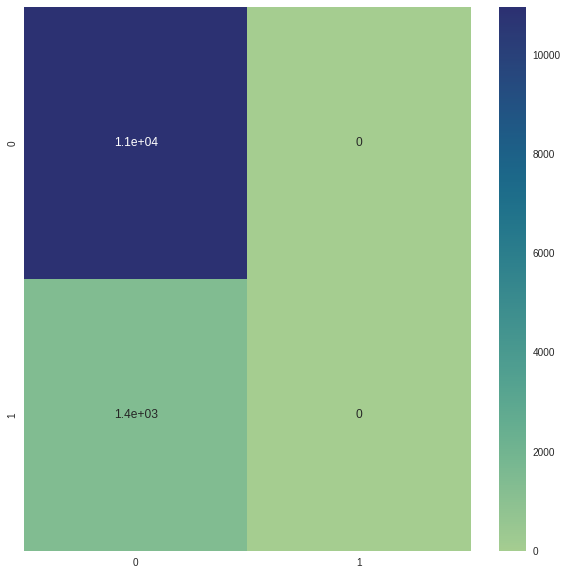



roc_auc is:
0.7793439111682497


In [ ]:
def predict_result_outputer(model = log_reg_w_sm, y = 'Outcome', df = df_test, X = X_test, from_sm = False, from_sk = False,thre = 0.3): 
    
    df_w_result = df.copy()
    if from_sk:
        df_w_result['score'] = [i[1] for i in model.predict_proba(X)]
    elif from_sm:
        df_w_result['score'] = [i for i in model.predict(sm.add_constant(X))]
    else:
        df_w_result['score'] = [i for i in model.predict(X)]
    
    import sklearn.metrics as sk_m
    print('R Square score between predict probability and real true/false decision  is:')
    print(sk_m.r2_score(df_w_result[y], df_w_result['score']))
    print('\n')
    print(f'Confusion Matrix with a threshold of {thre}')
    print(sk_m.confusion_matrix(np.ravel(df_w_result[y]), df_w_result['score']>thre))
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns
    # sensitivity heatmap of best threshold
    plt.figure(figsize=(10, 10))
    sns.heatmap(sk_m.confusion_matrix(np.ravel(df_w_result[y]), df_w_result['score']>thre),cmap="crest",annot=True)

    plt.show()
    print('\n')
    print('roc_auc is:')
    print(sk_m.roc_auc_score(df_w_result[y], df_w_result['score']))

predict_result_outputer(model = log_reg_w_sm, from_sm = True,thre = 1)


In [ ]:
from sklearn.linear_model import LogisticRegression 

log_reg_w_sk = LogisticRegression()
log_reg_w_sk.fit(X_train, y_train)


LogisticRegression()

R Square score between predict probability and real true/false decision  is:
0.17543796035864156


Confusion Matrix with a threshold of 0.3
[[10431   530]
 [  876   520]]


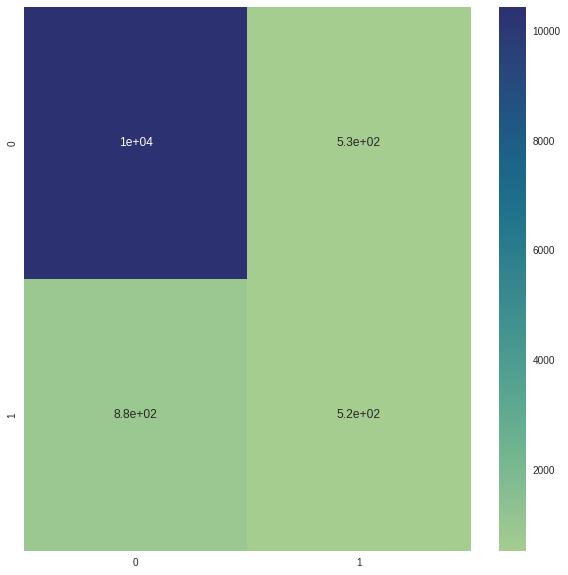



roc_auc is:
0.7793363302398789


In [ ]:
predict_result_outputer(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, from_sk = True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



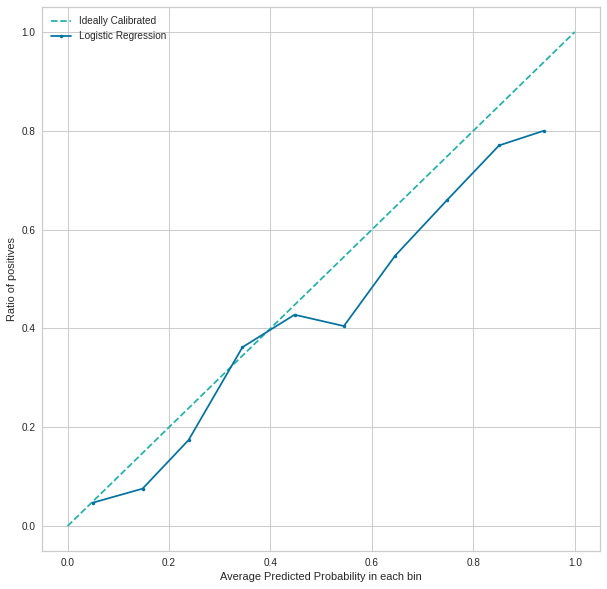

In [ ]:
from sklearn.calibration import calibration_curve
prob = log_reg_w_sm.predict(sm.add_constant(X_test))
y_test = df_test.copy()['Outcome']
x, y = calibration_curve(y_test, prob, n_bins = 10, normalize = True)

plt.figure(figsize=(10,10))

plt.plot([0, 1], [0, 1], color='lightseagreen',linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve
plt.plot(y, x, marker = '.', label = 'Logistic Regression')
 
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

# **Random Forests**

##### The code cells below is for PCA Random Forest

In [ ]:
import sklearn.model_selection as sk_ms
df_train, df_test = sk_ms.train_test_split(df_lr, train_size=0.7, random_state=123)

X_train = df_train.drop(columns = ['Outcome'])
y_train = df_train.Outcome
X_test = df_test.drop(columns = ['Outcome'])

In [ ]:
# Use df of logistic regression as the same df for random forests
df_rf = df_lr.copy()
# Train Test split 
import sklearn.model_selection as sk_ms

df_train_rf, df_test_rf = sk_ms.train_test_split(df_rf, train_size=0.7, random_state=123)

X_train_rf = df_train_rf.drop(columns = ['Outcome'])
y_train_rf = df_train_rf.Outcome
X_test_rf = df_test_rf.drop(columns = ['Outcome'])
y_test_rf = df_test_rf.Outcome

In [ ]:
# find the best random forest classifier model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = {
     'n_estimators':(10, 30, 50), #the number of trees
     'max_depth':(4,5,6,8,10,15),
     'min_samples_split': (2, 4, 8),
     'min_samples_leaf': (4,8,12,16)
}

model_rfc = GridSearchCV(RandomForestClassifier(),parameters,cv=5)
model_rfc.fit(X_train_rf, np.ravel(y_train_rf))
model_rfc.best_score_, model_rfc.best_params_

In [ ]:
# Best random forest model results
from sklearn.ensemble import RandomForestClassifier
model_rf_best = RandomForestClassifier(max_depth=10,min_samples_leaf=8,min_samples_split=2,n_estimators=50)
model_rf_best.fit(X_train_rf,np.ravel(y_train_rf))

from sklearn.metrics import confusion_matrix
y_pred_rf_best = model_rf_best.predict(X_test_rf)
print("The confusion matrix of randomforest classifier is: \n", confusion_matrix(y_test_rf,y_pred_rf_best))
print("\n\nThe score of the best random forest model on test data is: \n", model_rf_best.score(X_test_rf,y_test_rf))

In [ ]:
# Display variables from the most important to the least
import matplotlib.pyplot as plt
feature_names = X_train_rf.columns
%matplotlib inline
importances = model_rf_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightseagreen', align='center')
#plt.yticks(range(len(indices)),feature_names)
plt.yticks(range(len(indices)),np.array(feature_names)[indices])
plt.rc('ytick', labelsize=20) 
plt.xlabel('Relative Importance')

In [ ]:
# bootsrapping
from sklearn.ensemble import BaggingClassifier

parameters_bg = {
     'n_estimators':(30, 50), #the number of trees
     'max_samples':(30,40,50),
     'max_features':(5,10,20),
     #'oob_score':np.ravel(y_test)
}

# Find the best bootstrapping model parameters
model_bootp = GridSearchCV(BaggingClassifier(),parameters_bg,cv=5)
model_bootp.fit(X_train_rf, np.ravel(y_train_rf))
model_bootp.best_score_, model_bootp.best_params_

In [ ]:
# Best bootstrapping result
from sklearn.ensemble import BaggingClassifier
model_bootp_best = BaggingClassifier(max_features=10,max_samples=50,n_estimators=50)
model_bootp_best.fit(X_train_rf,np.ravel(y_train_rf))

y_pred_bootp_best = model_bootp_best.predict(X_test_rf)
print("The confusion matrix of bootstrapping classifier is: \n", confusion_matrix(y_test_rf,y_pred_bootp_best))
print("\n\nThe score of the best bootstrapping model on test data is: \n", model_bootp_best.score(X_test_rf,y_test_rf))

In [ ]:
plt.style.use('default')
sns.heatmap(confusion_matrix(y_test_rf,y_pred_bootp_best), annot=True, cmap = "crest")

##### The code cell below is only for NON-PCA random-forest

In [ ]:
# this function returns a list containing all column names with certain type
def type_list_generator(df, tp = 'object'):
    lt = []
    if type(tp) == str:
        for index, row in info_df_generator(df).iterrows():
            if row['dtype'] == tp:
                lt.append(row['feature'])
    if type(tp) == list:
        for index, row in info_df_generator(df).iterrows():
            if row['dtype'] in tp:
                lt.append(row['feature'])
    return lt

def df_w_dummy_generator(Regression = True, col = type_list_generator(df), df = df):
    
    if Regression:
        df_copy = pd.get_dummies(data = df, columns = col, drop_first = True)
    else:
        df_copy = pd.get_dummies(data = df, columns = col)
    return df_copy


df_lr1 = df_w_dummy_generator(Regression = True, col = ['y'], df=df_nonpca_rf)

# Avoid multicolinearity in Logistic Regression
# Drop Default because most of them are no
df_lr1.drop(columns = ['emp.var.rate', 'nr.employed','year','default','cons.price.idx','poutcome','loan','campaign','previous'],inplace = True)

df_lr1.columns = [i.replace('.', '_') for i in df_lr1.columns]

df_lr1.rename(columns = {'y_yes':'Outcome'},inplace = True)

# Logistic Preprocessing
from sklearn import preprocessing
l1 = type_list_generator(df_lr1,'int64')
l2 = type_list_generator(df_lr1,'float64')
l1.extend(l2)
df_lr1[l1] = df_lr1[l1].apply(lambda col: preprocessing.scale(col), axis = 0)

In [ ]:
# Use df of logistic regression as the same df for random forests
df_rf = df_lr1.copy()
# Train Test split 
import sklearn.model_selection as sk_ms

df_train_rf, df_test_rf = sk_ms.train_test_split(df_rf, train_size=0.7, random_state=123)

X_train_rf = df_w_dummy_generator(Regression = False, col = type_list_generator(df_rf), df = df_train_rf.drop(columns = ['Outcome']))
y_train_rf = df_train_rf.Outcome
X_test_rf = df_w_dummy_generator(Regression = False, col = type_list_generator(df_rf), df = df_test_rf.drop(columns = ['Outcome']))
y_test_rf = df_test_rf.Outcome

In [ ]:
# find the best random forest classifier model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters = {
     'n_estimators':(10, 30, 50), #the number of trees
     'max_depth':(4,5,6,8,10,15),
     'min_samples_split': (2, 4, 8),
     'min_samples_leaf': (4,8,12,16)
}

model_rfc = GridSearchCV(RandomForestClassifier(),parameters,cv=5)
model_rfc.fit(X_train_rf, np.ravel(y_train_rf))
model_rfc.best_score_, model_rfc.best_params_

In [ ]:
# Best random forest model results
model_rf_best = RandomForestClassifier(max_depth=15,min_samples_leaf=8,min_samples_split=8,n_estimators=50)
model_rf_best.fit(X_train_rf,np.ravel(y_train_rf))

from sklearn.metrics import confusion_matrix
y_pred_rf_best = model_rf_best.predict(X_test_rf)
print("The confusion matrix of randomforest classifier is: \n", confusion_matrix(y_test_rf,y_pred_rf_best))
print("\n\nThe score of the best random forest model on test data is: \n", model_rf_best.score(X_test_rf,y_test_rf))

In [ ]:
# Display variables from the most important to the least
import matplotlib.pyplot as plt
feature_names = X_train_rf.columns
%matplotlib inline
importances = model_rf_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
#plt.yticks(range(len(indices)),feature_names)
plt.yticks(range(len(indices)),np.array(feature_names)[indices])
plt.xlabel('Relative Importance')

In [ ]:
# bootsrapping
from sklearn.ensemble import BaggingClassifier

parameters_bg = {
     'n_estimators':(30, 50), #the number of trees
     'max_samples':(30,40,50),
     'max_features':(5,10,20),
     #'oob_score':np.ravel(y_test)
}

# Find the best bootstrapping model parameters
model_bootp = GridSearchCV(BaggingClassifier(),parameters_bg,cv=5)
model_bootp.fit(X_train_rf, np.ravel(y_train_rf))
model_bootp.best_score_, model_bootp.best_params_

In [ ]:
# Best bootstrapping result
from sklearn.ensemble import BaggingClassifier

model_bootp_best = BaggingClassifier(max_features=20,max_samples=30,n_estimators=30)
model_bootp_best.fit(X_train_rf,np.ravel(y_train_rf))

y_pred_bootp_best = model_bootp_best.predict(X_test_rf)
print("The confusion matrix of bootstrapping classifier is: \n", confusion_matrix(y_test_rf,y_pred_bootp_best))
print("\n\nThe score of the best bootstrapping model on test data is: \n", model_bootp_best.score(X_test_rf,y_test_rf))

In [ ]:
plt.style.use('default')
sns.heatmap(confusion_matrix(y_test_rf,y_pred_bootp_best), annot=True, cmap = "crest")

#**Address Data Imbalance Problem**
- The distribution of dependent variable, y, is very skewed towards "no", with approxiately 7:1 ratio
- Use SMOTE-NC technique to upsample minority data ('yes' in y) to address data imbalance problem

In [ ]:
from imblearn.over_sampling import SMOTENC
from collections import Counter

In [ ]:
# change column order
cols = df.columns.tolist()
cols = cols[:-3]+[cols[-1]]+[cols[-2]]
# one-hot encoding
df_copy = pd.get_dummies(data = df[cols], drop_first = True)

In [ ]:
df_copy = pd.concat([pd.DataFrame(preprocessing.scale(df_copy.iloc[:,0:8]),columns = df_copy.columns[0:8]),df_copy.iloc[:,8:]],axis=1)

In [ ]:
df_copy

In [ ]:
# df_copy.drop(columns = ['emp.var.rate','year','cons.price.idx'],inplace = True)
# X = df_copy.iloc[:,0:43]
X = df_copy.iloc[:,0:46]
y = df_copy['y_yes']

# here we can see y is imbalanced
counter = Counter(y)
counter

In [ ]:
import seaborn as sns
sns.lmplot(x='age', y='campaign', data=df_copy, hue='y_yes', fit_reg=False)

In [ ]:
import sklearn.model_selection as sk_ms
X_train, X_test, y_train, y_test = sk_ms.train_test_split(X,y, train_size = 0.7, random_state = 123)

In [ ]:
# start oversampling the train data, since we have both categorical and continuous variable, we should use SMOTRE-NC technique instead of SMOTE
# smotenc = SMOTENC( np.arange(5,43),random_state = 123)
smotenc = SMOTENC( np.arange(5,46),random_state = 123)
X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)
# now the sample is balanced
Counter(X_oversample['y_yes'])

In [ ]:
import seaborn as sns
sns.lmplot(x='age', y='campaign', data=X_oversample, hue='y_yes', fit_reg=False)

In [ ]:
X_oversample

In [ ]:
# try logistics reg after upsampling
#Classifier with SMOTE-NC
import sklearn.linear_model as sk_lm
import sklearn.metrics as sk_m
classifier_o = sk_lm.LogisticRegression(penalty='none',max_iter=90)
classifier_o.fit(X_oversample, y_oversample)
df_copy['score'] = [i[1] for i in classifier_o.predict_proba(X)]
sk_m.roc_auc_score(df_copy.iloc[y_test.index]['y_yes'], df_copy.iloc[y_test.index]['score'])


In [ ]:
roc_drawer(model = classifier_o, y = 'y_yes', df = df_copy.iloc[y_test.index], X = X_test,  from_sk = True)

In [ ]:
from sklearn.calibration import calibration_curve
prob = [i[1] for i in classifier_o.predict_proba(X_test)]
x, y = calibration_curve(y_test, prob, n_bins = 10, normalize = True)

plt.figure(figsize = (8,8))

plt.plot([0, 1], [0, 1],color = 'salmon',linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve

plt.plot(y, x, color='darkturquoise',marker = '.', label = 'Logistic Regression')
 
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

# **Double-checking the after-SMOTENC AUC: Using SVM**
- linear separability

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import confusion_matrix, accuracy_score 
# from sklearn.ensemble import BaggingClassifier
svc_smotenc = SVC(kernel='rbf', C=1000, gamma = 0.001, decision_function_shape = 'ovo',probability = True)
svc_smotenc.fit(X_oversample, y_oversample)
y_pred_svc = svc_smotenc.predict(X_test)
accuracy = accuracy_score(y_test,y_pred_svc)*100
confusion_mat = confusion_matrix(y_test,y_pred_svc)
import seaborn as sns
sns.heatmap(confusion_mat, annot=True, cmap = "crest")

In [ ]:
roc_drawer(model = svc_smotenc, y = 'y_yes', df = df_copy.iloc[y_test.index], X = X_test, from_sk = True)

In [ ]:
# what if we don't use the SMOTENC simulated data?
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import confusion_matrix, accuracy_score 
svc_null = SVC(kernel='rbf', C=1000, gamma = 0.001, decision_function_shape = 'ovo', probability = True)
svc_null.fit(X_train, y_train)
y_pred_svc_null= svc_null.predict(X_test)
accuracy = accuracy_score(y_test,y_pred_svc_null)*100
confusion_mat = confusion_matrix(y_test,y_pred_svc_null)
print(accuracy)
sns.heatmap(confusion_mat, annot=True, cmap = "crest")

In [ ]:
roc_drawer(model = svc_smotenc, y = 'y_yes', df = df_copy.iloc[y_test.index], X = X_test,  from_sk = True)

# **Economic explanations**

In [ ]:
# Plot the relationship between euribor-3-month and confidence index
economic_df = df[['euribor3m', 'cons.price.idx', 'cons.conf.idx', 'day_of_week','month']]
economic_df = economic_df.drop_duplicates()
economic_df = economic_df.reset_index(drop=True)

euribor3m = economic_df['euribor3m']
CPI = economic_df['cons.price.idx']
CCI = economic_df['cons.conf.idx']
plt.plot(euribor3m)
plt.xlabel('Day')
plt.ylabel('Interest rate (%)')

In [ ]:
def find_best_classifier(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, m = 0.2, profit_customer = 1.25):
    """
    Creating cost matrix; using the dot multiplication of cost matrix and confusion matrix to get the the best payoff with the best threshold.
    """
    df_w_result = df.copy()
    df_w_result['score'] = [i[1] for i in model.predict_proba(X)]
    
    payoff = []
    threshold = [x/1000 for x in range(10, 1001, 5)]
    # duration is in seconds unit
    cost = 25*(duration.mean()/60/60) + 8
    profit_matrix = np.array([[0, -cost,profit_customer, -cost+profit_customer*(1+m)]]).reshape(2,2)

    best_threshold = 0
    best_payoff = 0
    
    import sklearn.metrics as sk_m
    for i in threshold:
        conf_matrix = sk_m.confusion_matrix(np.ravel(df_w_result[y]), df_w_result['score']>i)
        pay = sum(sum(conf_matrix * profit_matrix))
        payoff.append(pay)

        if pay > best_payoff:
            best_payoff = pay
            best_threshold = i
    
    return best_threshold, best_payoff, threshold, payoff

In [ ]:
# Plot the various payoff levels with respective threshold levels
import matplotlib.pyplot as plt
   
threshold = find_best_classifier(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, m = 0.2, profit_customer = 25)[2]
payoff = find_best_classifier(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, m = 0.2, profit_customer = 25)[3]
  
plt.plot(threshold, payoff)
plt.title('threshold vs payoff')
plt.xlabel('threshold')
plt.ylabel('payoff')
plt.show()

In [ ]:
# The best threshold and the largest payoff assuming m=0.2 and profit_customer=1.25
best_th = find_best_classifier(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, m = 0.2, profit_customer = 25)[0]
best_pay = find_best_classifier(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, m = 0.2, profit_customer = 25)[1]
print("The best threshold is {} and the largest payoff is {}".format(best_th, best_pay))

In [ ]:
# Sensitivity analysis: Try various input levels for the parameter m and profit_consumer to get different levels of payoffs and best threshold
best_threshold = []
best_payoff = []
for i in [0.1,0.2,0.3,0.4,0.5]:
    sub_threshold = []
    sub_payoff = []
    for j in [25,50,75,100,125]:
        sub_threshold.append(find_best_classifier(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, m = i, profit_customer = j)[0])
        sub_payoff.append(find_best_classifier(model = log_reg_w_sk, y = 'Outcome', df = df_test, X = X_test, m = i, profit_customer = j)[1])
    best_threshold.append(sub_threshold)
    best_payoff.append(sub_payoff)

In [ ]:
# Construct the sensitivity table, with column equals to different inputs of profit_consumer, index equals to inputs of m
profit_consumer_list = [25,50,75,100,125]
m_list = [0.1,0.2,0.3,0.4,0.5]
threshold_table = pd.DataFrame(best_threshold, columns=profit_consumer_list, index=m_list)
payoff_table = pd.DataFrame(best_payoff, columns=profit_consumer_list, index=m_list)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sensitivity heatmap of best threshold
sns.heatmap(threshold_table,annot=True)
plt.show

In [ ]:
# sensitivity heatmap of best payoff
sns.heatmap(payoff_table,annot=True)
plt.show